In [1]:
import numpy as np
import pandas as pd
import requests
import zipfile
import altair as alt
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

## Title : Abalone Age Prediction based on Physical Measurements and Sex

## Summary - 1:

In this project, we aimed to build a regression model using the k-Nearest Neighbours (k-NN) algorithm to predict the age of an abalone using its physical characteristics and sex. Since determining abalone age traditionally requires cutting the shell and counting rings (a destructive and time-consuming process), machine learning methods offer a non-destructive alternative for estimating age from easily measurable features. Age in this dataset is represented as Rings + 1.5, where each ring corresponds roughly to one year of growth and the additional 1.5 accounts for early development. For example, an abalone with 10 rings would be approximately 11.5 years old.

Our k-NN Regressor (with $k=5$) produced an RMSE of approximately 2.2 rings on the test set, meaning the model’s predictions deviate from the true age by about 2 rings on average. The scatter plot of actual versus predicted values shows a generally increasing trend but with noticeable spread, especially among older abalones. This indicates that while k-NN captures broad growth patterns, predicting exact age remains challenging due to natural biological variability and overlapping physical features. Nevertheless, the model produces reasonable baseline performance and demonstrates that physical measurements contain meaningful information about abalone age. Further improvement could be achieved by tuning $k$ or exploring more complex models.

## Introduction - 2

#### 2.1 Project Goal:
Understand if physical features and sex can accurately predict the age of an abalone.

#### 2.2 Background:
Abalones are a type of marine mollusk widely harvested for food and shell products. Understanding their age is important for marine biology research, sustainable fisheries management, and conservation efforts. However, determining the age of an abalone is not straightforward. The most accurate method requires cutting the shell and counting the number of rings inside under a microscope—an approach that is destructive, labor-intensive, and not feasible at scale for monitoring wild populations.

The Abalone dataset from the UCI Machine Learning Repository provides measurements of physical characteristics such as shell length, diameter, height, whole weight, shucked weight, viscera weight, and shell weight. These variables are non-destructive measurements that can be collected easily and consistently. Since abalone age is strongly related to its size and mass, this dataset provides an opportunity to use machine learning to predict an abalone’s age from its measurable physical features.

Age in this dataset is recorded using the variable Rings, where Age = Rings + 1.5 years, reflecting the biological growth process of shell formation. Because Rings is a numeric, continuous output, predicting age is naturally formulated as a regression problem.


## Methods - 3

#### 3.1 Model Selection:

k-Nearest Neighbours (k-NN) Regressor is our chosen model to predict the age of an abalone from it's physical characteristics and sex.

This model estimates the age of a new abalone by finding the k most similar abalones in the training set, where similarity is measured using Euclidean distance in the standardized feature space and averaging their observed ring counts. 

We selected k-NN because it is a simple, easily interpretable, and non-parametric model that does not assume linear relationships between predictors and age. Because abalone growth patterns are expected to be non-linear — with shell dimensions increasing quickly when young and more slowly with age — a flexible model such as k-NN is well suited to capture these unknown relationships between physical characteristics, sex, and age.

#### 3.2 Preprocessing Steps:

Prior to model fitting, all numeric features were standardized with Standard Scaler to ensure that measurements on different scales contributed equally to the distance calculations. One Hot Encoding is performed on the Sex categorical feature.

Hyperparameter tuning for k will be performed in future analysis for simplicity, as noted in the Milestone 1 project instructions as well. 

Scoring of the model will be based on Root Mean Squared Error (RMSE), since the target variable (Rings) is a continous variable. RMSE also penalizes large errors more heavily, which is desirable for age estimations as predicting an abalone to be far older or younger than it truly is is more problematic than small deviations.

## Discussion - 4:

#### 4.1 Exploratory Data Analysis Discussion
The exploratory data analysis reveals that most physical features, including length, diameter, height, and the different weight measurements are positively associated with the number of rings. In general, larger and heavier abalones tend to be older. However, these relationships are clearly nonlinear: growth accelerates when abalones are young and gradually tapers off, producing curved patterns in the scatterplot matrix. As measurements increase, the variability in ring counts also widens, indicating that abalones with similar sizes can still differ noticeably in age. This suggests that simple linear models may struggle to capture the underlying structure.

Among the predictors, height appears to be the least informative due to its narrow range and low variability. By contrast, the various weight variables (whole weight, shucked weight, viscera weight, and shell weight) show strong and highly correlated patterns, reinforcing the need for feature scaling to prevent any single weight variable from dominating distance calculations later in modeling.

The three sex categories (Male, Female, and Infant) overlap heavily across all measurements, with no visually distinct patterns separating them. At Milestone 1 of this project, for simplicity, we assume that "sex" alone is not a strong indicator of age. However, it is still included as a categorical feature via one-hot encoding, as we want to retain this feature for future analysis.

Overall, the nonlinear growth patterns, strong correlations among weight-based predictors, and high degree of feature overlap support our choice of a k-Nearest Neighbours model. kNN is well suited to datasets where local structure matters and where the relationship between predictors and the target does not follow a simple linear form.

In [2]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

column_names = [
    "Sex", "Length", "Diameter", "Height",
    "Whole_weight", "Shucked_weight",
    "Viscera_weight", "Shell_weight", "Rings"
]
abalone = pd.read_csv(url, header=None, names=column_names)

abalone.to_csv("data/abalone.csv", index=False)

In [3]:
abalone

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [4]:
# Excluding column: Sex for cleaner display of graphs
new_column_names = ["Length", "Diameter", "Height",
    "Whole_weight", "Shucked_weight",
    "Viscera_weight", "Shell_weight", "Rings"
]

# Plot all variables against one another for EDA
chart = alt.Chart(abalone,width=150, height=100).mark_point().encode(
  alt.X(alt.repeat('row'), type='quantitative'),
  alt.Y(alt.repeat('column'), type='quantitative'),
    color='Sex:N'
).repeat(column = new_column_names, row = new_column_names
).properties(title = "Scatterplot matrix")

chart

/Users/williamchong/miniforge3/envs/dsci_522_lab_env/lib/python3.12/site-packages/altair/utils/data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(


alt.RepeatChart(...)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# 1. One-hot encode the Sex categorical variable
# get_dummies() converts categories (M, F, I) -> columns Sex_F and Sex_M
# drop_first=True avoids creating redundant dummy columns

abalone_converted = pd.get_dummies(abalone, columns=["Sex"], drop_first=True)

# 2. Split predictors (X) and target variable (y)
# "Rings" is the target we want to predict (continuous -> regression)

X = abalone_converted.drop("Rings", axis=1)
y = abalone_converted["Rings"]
abalone_converted.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,True,False


In [6]:

# 3. Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 4. Standardize numeric features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# 5. Define the k-NN Regressor model
# weights="uniform" -> all neighbors contribute equally
# metric="minkowski", p=2 -> Euclidean distance
knn = KNeighborsRegressor(
    n_neighbors = 5,
    weights = "uniform",
    metric = "minkowski",
    p=2
)

# 6. Make predictions on both train and test sets
knn.fit(X_train_scaled, y_train)
y_train_pred = knn.predict(X_train_scaled)
y_test_pred  = knn.predict(X_test_scaled)

# 7. Evaluate performance using RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("=== KNN Regression performance (k=5) ===")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test  RMSE : {test_rmse:.4f}")

=== KNN Regression performance (k=5) ===
Train RMSE : 1.8626
Test  RMSE : 2.2884


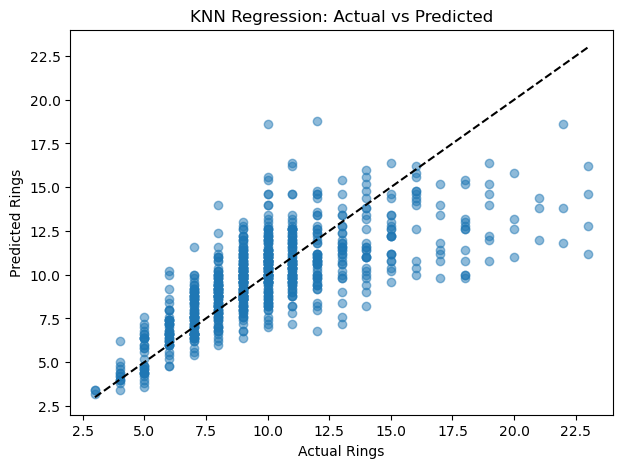

In [7]:
#8. Plot Actual vs Predicted Rings for visual inspection
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_test_pred, alpha=0.5)

plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="black"
)

plt.xlabel("Actual Rings")
plt.ylabel("Predicted Rings")
plt.title("KNN Regression: Actual vs Predicted")
plt.show()

## References: 

Dua, D., & Graff, C. (1995). Abalone Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/1/abalone

Nash, W. J., Sellers, T. L., Talbot, S. R., Cawthorn, A. J., & Ford, W. B. (1994). The Population Biology of Abalone (Haliotis species) in Tasmania. I. Blacklip Abalone (H. rubra) from the North Coast and Islands of Bass Strait. Sea Fisheries Division Technical Report No. 48.

Waugh, S. (1995). Extending and benchmarking Cascade-Correlation (PhD thesis). Department of Computer Science, University of Tasmania.

Clark, D., Schreter, Z., & Adams, A. (1996). A Quantitative Comparison of Dystal and Backpropagation. Proceedings of the Australian Conference on Neural Networks (ACNN’96).